In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend_laplace import PDESolverLaplace
from PDE_solver_backend_laplace import AggregateLaplace
from random import shuffle


In [3]:
def make_points_inside(Nd):
    return 2*np.random.rand(Nd,2)-1

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

In [4]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)
f_symbolic

65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

In [5]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.zeros_like(x)#np.power(x,3)
dtau=lambda x:np.zeros_like(x)

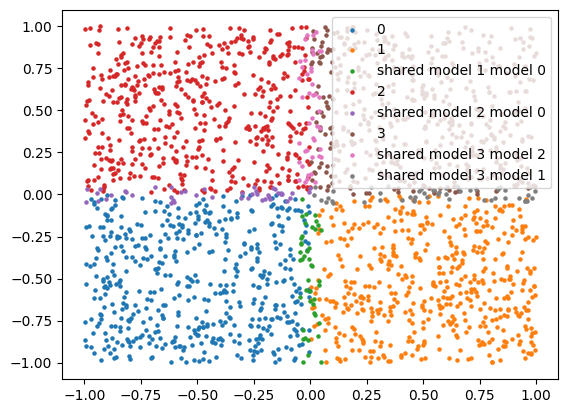

In [6]:
int_point_number=2000
ext_point_number=500
width=2
sigma=0.1
boundary_width=0.05

models=[]
X_boundary=make_points_boundary(ext_point_number)
for i in range(width**2):
    X_int=make_points_inside(int_point_number)
    yi=i//width
    xi=i%width
    selection=(-1+2*xi/width<X_int[:,0])&(X_int[:,0]<-1+2*(xi+1)/width)
    selection=selection & (-1+2*yi/width<X_int[:,1])&(X_int[:,1]<-1+2*(yi+1)/width)
    X_int=X_int[selection]

    plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)
    selection=X_boundary[:,0]>1000
    if i%width==0:
        selection=selection | (-1+2*yi/width<X_boundary[:,1])&(X_boundary[:,1]<-1+2*(yi+1)/width)&(X_boundary[:,0]<0)
    if i%width==width-1:
        selection=selection | (-1+2*yi/width<X_boundary[:,1])&(X_boundary[:,1]<-1+2*(yi+1)/width)&(X_boundary[:,0]>0)
    if i//width==0:
        selection=selection | (-1+2*xi/width<X_boundary[:,0])&(X_boundary[:,0]<-1+2*(xi+1)/width)&(X_boundary[:,1]<0)
    if i//width==width-1:
        selection=selection | (-1+2*xi/width<X_boundary[:,0])&(X_boundary[:,0]<-1+2*(xi+1)/width)&(X_boundary[:,1]>0)
    
    models.append(
        PDESolverLaplace(
            X_int=X_int,
            X_boundary=X_boundary[selection],
            sigma=sigma,
            name=f'model {i}')
    )
    if i%width>0:
        X_shared=make_points_inside(int_point_number)
        selection=(-1+2*xi/width-boundary_width<X_shared[:,0])&(X_shared[:,0]<-1+2*xi/width+boundary_width)
        selection=selection & (-1+2*yi/width<X_shared[:,1])&(X_shared[:,1]<-1+2*(yi+1)/width)
        models[-1].add_neighbors([models[-2]], [X_shared[selection]])
        models[-2].add_neighbors([models[-1]], [X_shared[selection]])
        plt.scatter(X_shared[selection][:,0],X_shared[selection][:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
    if i//width>0:
        X_shared=make_points_inside(int_point_number)
        selection=(-1+2*xi/width<X_shared[:,0])&(X_shared[:,0]<-1+2*(xi+1)/width)
        selection=selection & (-1+2*yi/width-boundary_width<X_shared[:,1])&(X_shared[:,1]<-1+2*yi/width+boundary_width)
        models[-1].add_neighbors([models[-1-width]], [X_shared[selection]])
        models[-1-width].add_neighbors([models[-1]], [X_shared[selection]])
        plt.scatter(X_shared[selection][:,0],X_shared[selection][:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

plt.legend()
plt.show()
PDESolverLaplace.joint_fit(models,f,real_u)


In [7]:
aggregate=AggregateLaplace(models,nugget=1e-5)

In [8]:
def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

local_aggregate=partial(dumb_aggregate,models=models,width=width)

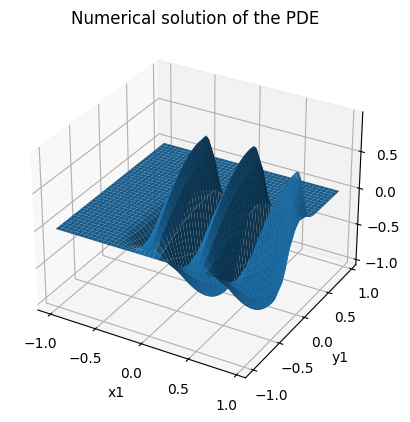

In [9]:
fig=plot_vectorized_function(models[1],0.05)
plt.title('Numerical solution of the PDE')
plt.show()

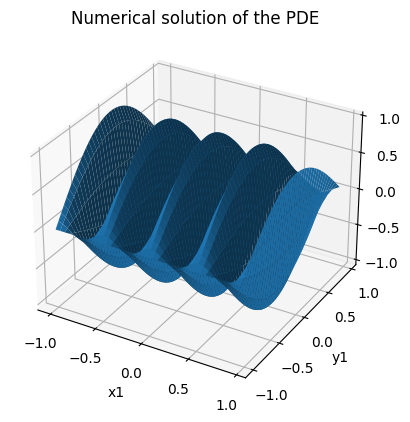

In [10]:
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

M [[ 2.97815858e-05  5.99663530e-22  6.03775714e-20  6.42573229e-46]
 [ 9.49757966e-07  5.80668281e-20  4.95987883e-20  5.61876139e-43]
 [ 1.22494770e-06  4.31376237e-18  2.81014830e-20  1.21063714e-40]
 ...
 [ 1.24106982e-33 -9.61156078e-18 -2.71890055e-14 -2.45489125e-02]
 [ 1.53987545e-35 -2.69283040e-18 -4.52294467e-16  2.40378132e-02]
 [ 1.48796263e-37  3.23601401e-18 -5.80659891e-18  6.34121859e-02]]
COV mat [[[ 1.00000254e+00  4.01600952e-25  5.97821750e-25 -1.88276841e-49]
  [ 4.01600952e-25  1.00000000e-05  1.93603740e-43  2.73065734e-64]
  [ 5.97821750e-25  1.93603740e-43  1.00000000e-05  2.39322702e-66]
  [-1.88276841e-49  2.73065734e-64  2.39322702e-66  1.00000000e-05]]

 [[ 1.00000582e+00  1.21075929e-25 -8.17563171e-26  2.11128463e-47]
  [ 1.21075929e-25  1.00000000e-05  1.79820103e-41  4.21629899e-60]
  [-8.17563171e-26  1.79820103e-41  1.00000000e-05 -2.04223877e-62]
  [ 2.11128463e-47  4.21629899e-60 -2.04223877e-62  1.00000000e-05]]

 [[ 1.00000507e+00  1.05383989e-21

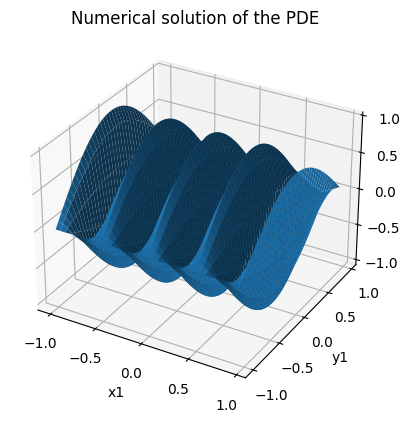

In [11]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [12]:
print(1/0)

ZeroDivisionError: division by zero

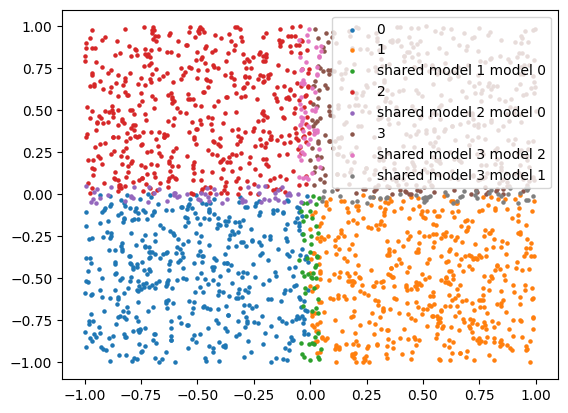

In [ ]:
int_point_number=2000
ext_point_number=1000
width=2
sigma=0.1
boundary_width=0.05

models=[]
X_boundary=make_points_boundary(ext_point_number)
for i in range(width**2):
    X_int=make_points_inside(int_point_number)
    yi=i//width
    xi=i%width
    selection=(-1+2*xi/width<X_int[:,0])&(X_int[:,0]<-1+2*(xi+1)/width)
    selection=selection & (-1+2*yi/width<X_int[:,1])&(X_int[:,1]<-1+2*(yi+1)/width)
    X_int=X_int[selection]

    plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)
    selection=X_boundary[:,0]>1000
    if i%width==0:
        selection=selection | (-1+2*yi/width<X_boundary[:,1])&(X_boundary[:,1]<-1+2*(yi+1)/width)&(X_boundary[:,0]<0)
    if i%width==width-1:
        selection=selection | (-1+2*yi/width<X_boundary[:,1])&(X_boundary[:,1]<-1+2*(yi+1)/width)&(X_boundary[:,0]>0)
    if i//width==0:
        selection=selection | (-1+2*xi/width<X_boundary[:,0])&(X_boundary[:,0]<-1+2*(xi+1)/width)&(X_boundary[:,1]<0)
    if i//width==width-1:
        selection=selection | (-1+2*xi/width<X_boundary[:,0])&(X_boundary[:,0]<-1+2*(xi+1)/width)&(X_boundary[:,1]>0)
    
    models.append(
        PDESolverLaplace(
            X_int=X_int,
            X_boundary=X_boundary[selection],
            sigma=sigma,
            name=f'model {i}')
    )
    if i%width>0:
        X_shared=make_points_inside(int_point_number)
        selection=(-1+2*xi/width-boundary_width<X_shared[:,0])&(X_shared[:,0]<-1+2*xi/width+boundary_width)
        selection=selection & (-1+2*yi/width<X_shared[:,1])&(X_shared[:,1]<-1+2*(yi+1)/width)
        models[-1].add_neighbors([models[-2]], [X_shared[selection]])
        models[-2].add_neighbors([models[-1]], [X_shared[selection]])
        plt.scatter(X_shared[selection][:,0],X_shared[selection][:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
    if i//width>0:
        X_shared=make_points_inside(int_point_number)
        selection=(-1+2*xi/width<X_shared[:,0])&(X_shared[:,0]<-1+2*(xi+1)/width)
        selection=selection & (-1+2*yi/width-boundary_width<X_shared[:,1])&(X_shared[:,1]<-1+2*yi/width+boundary_width)
        models[-1].add_neighbors([models[-1-width]], [X_shared[selection]])
        models[-1-width].add_neighbors([models[-1]], [X_shared[selection]])
        plt.scatter(X_shared[selection][:,0],X_shared[selection][:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

plt.legend()
plt.show()



In [ ]:
def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

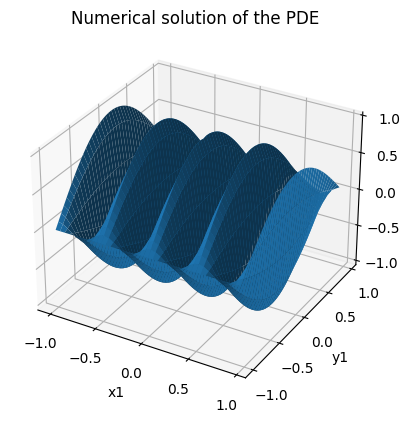

In [ ]:
for model in models:
    model.setup_fit(f,real_u)
ms=[m for m in models]
for _ in range(10000):
    shuffle(ms)
    for m in ms:
        m.fit()
    for m in ms:
        m.solved_shared={key:False for key in m.solved_shared.keys()}
local_aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
models[1].shared_value

{model 0: array([ 0.65971738,  0.53926194,  0.39814522,  0.63525182,  0.5988574 ,
         0.58401576,  0.65726654,  0.66379365,  0.16412308,  0.5841959 ,
         0.02690619,  0.27392163,  0.61743813,  0.2890659 ,  0.58909474,
         0.5833318 ,  0.33411465,  0.06377921,  0.3762564 , -0.48033415,
         0.07682341,  0.59922422,  0.57933601,  0.28158314]),
 model 3: array([-0.01295531,  0.00514756,  0.00476922,  0.06910905, -0.00545182,
         0.02253136,  0.01646729,  0.04135628,  0.02308617, -0.2527073 ,
        -0.28471258,  0.0948906 ,  0.01207235, -0.09224275,  0.22069084,
        -0.04793439,  0.27681123,  0.12870829,  0.31072972,  0.16978361,
        -0.33814486, -0.4356767 ,  0.7442888 ])}

In [ ]:
local_aggregate=partial(dumb_aggregate,models=models,width=width)

In [ ]:
models[1].shared_value

{model 0: array([ 0.65971738,  0.53926194,  0.39814522,  0.63525182,  0.5988574 ,
         0.58401576,  0.65726654,  0.66379365,  0.16412308,  0.5841959 ,
         0.02690619,  0.27392163,  0.61743813,  0.2890659 ,  0.58909474,
         0.5833318 ,  0.33411465,  0.06377921,  0.3762564 , -0.48033415,
         0.07682341,  0.59922422,  0.57933601,  0.28158314]),
 model 3: array([-0.01295531,  0.00514756,  0.00476922,  0.06910905, -0.00545182,
         0.02253136,  0.01646729,  0.04135628,  0.02308617, -0.2527073 ,
        -0.28471258,  0.0948906 ,  0.01207235, -0.09224275,  0.22069084,
        -0.04793439,  0.27681123,  0.12870829,  0.31072972,  0.16978361,
        -0.33814486, -0.4356767 ,  0.7442888 ])}

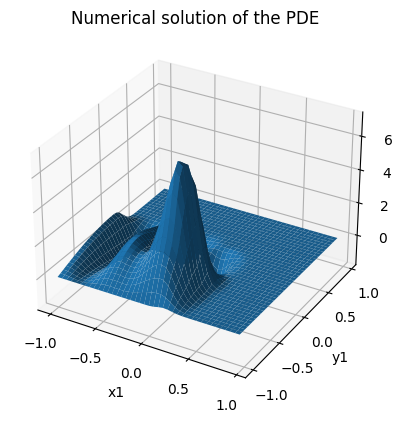

In [ ]:
fig=plot_vectorized_function(models[0],0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
models[0].shared_value

{model 1: array([6.12697191, 3.41763793, 2.69971611, 4.7921968 , 3.30800085,
        1.87328746, 6.01656481, 2.01680298, 6.56162425, 4.41321383,
        4.64266547, 2.07775726, 3.54707387]),
 model 2: array([-0.84286692,  0.65328943,  0.87721182,  0.19290001,  0.21098234,
         1.05872251, -0.77196441, -0.7789662 , -0.76244317, -0.83899985,
        -0.41838974,  0.14768389,  0.8273163 , -0.0713392 ,  0.63807151,
        -0.9855597 ,  0.39946594, -0.27574332, -0.18789508, -0.96344259,
        -0.60064037, -0.43381709,  0.57176355, -0.41728608,  0.25939664,
        -0.56035117,  0.52861966,  0.41026344])}

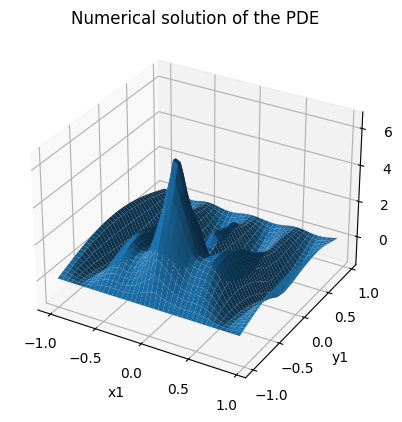

In [ ]:
fig=plot_vectorized_function(local_aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
aggregate=AggregateLaplace(models,nugget=1e-5)

M [[-1.37568848e-05  5.11397348e-21 -2.71605343e-18  4.26450541e-42]
 [ 5.07536972e-05  5.78709902e-19 -3.73943633e-18  6.50222773e-40]
 [-1.01682445e-05  5.07240076e-17 -4.37498058e-18  7.70757159e-38]
 ...
 [ 2.05007291e-35  1.13477448e-17 -1.49069418e-13 -3.32799019e-02]
 [ 5.01065868e-37  1.92788293e-17 -2.15674634e-15  1.88361280e-02]
 [ 7.76803539e-39  2.51866315e-17 -2.41796412e-17  6.17305627e-02]]
COV mat [[[ 1.00000491e+00  2.84604211e-26 -2.18664472e-25 -7.78175753e-50]
  [ 2.84604211e-26  1.00000000e-05 -1.29652546e-43  7.57686498e-65]
  [-2.18664472e-25 -1.29652546e-43  1.00000000e-05 -2.22561627e-64]
  [-7.78175753e-50  7.57686498e-65 -2.22561627e-64  1.00000000e-05]]

 [[ 1.00000232e+00 -1.92620763e-25  2.51472021e-25  2.05644660e-47]
  [-1.92620763e-25  1.00000000e-05 -1.30899490e-41  1.21715387e-60]
  [ 2.51472021e-25 -1.30899490e-41  1.00000000e-05 -1.00948882e-61]
  [ 2.05644660e-47  1.21715387e-60 -1.00948882e-61  1.00000000e-05]]

 [[ 1.00000781e+00 -3.50384937e-23

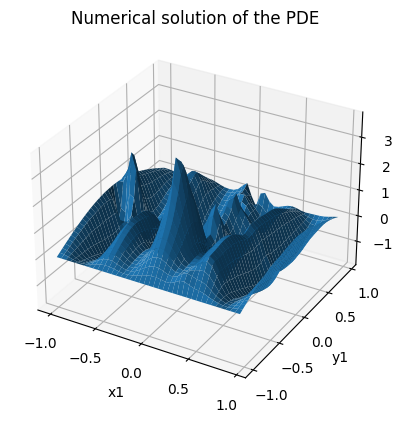

In [ ]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
print(1/0)

In [ ]:
u_right.K_inv

array([[ 9.07383132e+04,  5.03931666e+02,  5.59767793e+01, ...,
         7.08656717e+00,  3.80540314e-04,  7.42449281e+00],
       [ 5.03931666e+02,  5.87921178e+04,  7.52185594e+01, ...,
         7.27099925e+01, -2.42685639e-03,  1.27229558e+02],
       [ 5.59767793e+01,  7.52185594e+01,  5.22944094e+04, ...,
         8.57679656e+01,  9.92407411e-02, -3.52736505e+02],
       ...,
       [ 7.08656717e+00,  7.27099925e+01,  8.57679656e+01, ...,
         8.18682090e+03,  1.30849251e-02, -1.17107217e+02],
       [ 3.80540314e-04, -2.42685639e-03,  9.92407411e-02, ...,
         1.30849251e-02,  1.42198433e+00,  2.31918941e-03],
       [ 7.42449281e+00,  1.27229558e+02, -3.52736505e+02, ...,
        -1.17107217e+02,  2.31918941e-03,  5.01361361e+02]])

In [ ]:
int_point_number=1000
ext_point_number=200

X_int_left=make_points_inside(int_point_number)
X_int_left=X_int_left[X_int_left[:,0]<-0.3]
X_int_mid=make_points_inside(int_point_number)
X_int_mid=X_int_mid[X_int_mid[:,0]>-0.3]
X_int_mid=X_int_mid[X_int_mid[:,0]<0.3]
X_int_right=make_points_inside(int_point_number)
X_int_right=X_int_right[X_int_right[:,0]>0.3]
X_boundary_left=make_points_boundary(ext_point_number)
X_boundary_mid=make_points_boundary(ext_point_number)
X_boundary_right=make_points_boundary(ext_point_number)
X_boundary_left=X_boundary_left[X_boundary_left[:,0]<-0.3]
X_boundary_mid=X_boundary_mid[X_boundary_mid[:,0]>-0.3]
X_boundary_mid=X_boundary_mid[X_boundary_mid[:,0]<0.3]
X_boundary_right=X_boundary_right[X_boundary_right[:,0]>0.3]

X_shared_lm=make_points_inside(int_point_number)
X_shared_lm=X_shared_lm[(-0.35<X_shared_lm[:,0]) & (X_shared_lm[:,0]<-0.25)]
X_shared_rm=make_points_inside(int_point_number)
X_shared_rm=X_shared_rm[(0.25<X_shared_rm[:,0]) & (X_shared_rm[:,0]<0.35)]

sigma=0.1

u_left=PDESolverLaplace(X_int=X_int_left,X_boundary=X_boundary_left,sigma=sigma,name='left')
u_right=PDESolverLaplace(X_int=X_int_right,X_boundary=X_boundary_right,sigma=sigma,name='right')
u_mid=PDESolverLaplace(X_int=X_int_mid,X_boundary=X_boundary_mid,sigma=sigma,name='middle')

u_left.add_neighbors([u_mid], [X_shared_lm])
u_mid.add_neighbors([u_left], [X_shared_lm])
u_right.add_neighbors([u_mid], [X_shared_rm])
u_mid.add_neighbors([u_right], [X_shared_rm])

u_right.setup_fit(f,real_u)
u_left.setup_fit(f,real_u)
u_mid.setup_fit(f,real_u)


In [ ]:
ms=[u_right,u_left,u_mid]
for _ in range(10):
    shuffle(ms)
    for m in ms:
        m.fit()
    for m in ms:
        m.solved_shared={key:False for key in m.solved_shared.keys()}

changed: {(left, middle): (0, 49)}
changed: {(middle, right): (0, 48)}
changed: {}
changed: {(right, middle): (0, 48)}
changed: {(middle, left): (0, 49)}
changed: {}
changed: {(right, middle): (0, 48)}
changed: {(middle, left): (0, 49)}
changed: {}
changed: {(right, middle): (0, 48)}
changed: {(left, middle): (0, 49)}
changed: {}
changed: {(right, middle): (0, 48)}
changed: {(middle, left): (0, 49)}
changed: {}
changed: {(middle, left): (0, 49), (middle, right): (49, 97)}
changed: {}
changed: {}
changed: {(left, middle): (0, 49)}
changed: {(middle, right): (0, 48)}
changed: {}
changed: {(left, middle): (0, 49)}
changed: {(middle, right): (0, 48)}
changed: {}
changed: {(middle, left): (0, 49), (middle, right): (49, 97)}
changed: {}
changed: {}
changed: {(middle, left): (0, 49), (middle, right): (49, 97)}
changed: {}
changed: {}


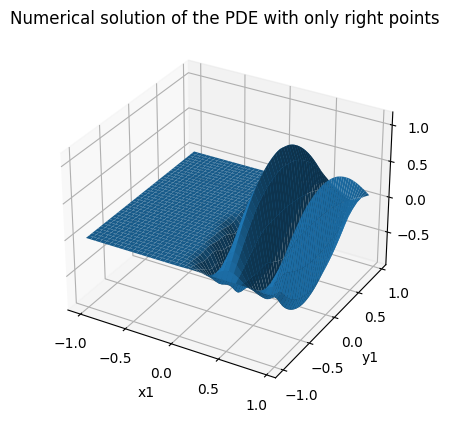

In [ ]:
fig=plot_vectorized_function(u_right)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

In [ ]:
u_mid.shared_value

{right: array([ 0.24344569,  0.17111637, -0.13373454, -0.12952834, -0.11864595,
         0.23787497, -0.47229337, -0.26900815, -0.06074471, -0.03607253,
         0.42431425, -0.18292284, -0.26632656, -0.4115816 ,  0.14181017,
        -0.37544418, -0.13764253, -0.11838088, -0.06040732,  0.27398539,
        -0.05094686, -0.10549157, -0.26162499, -0.00270284, -0.1802084 ,
         0.02504883, -0.13306502, -0.2721393 ,  0.01801082, -0.252773  ,
        -0.15552045, -0.19054249, -0.0364849 ,  0.05658698, -0.11409115,
        -0.01487321, -0.00716947, -0.09908292,  0.31967424, -0.28665095,
        -0.15783903, -0.20460618, -0.04995344,  0.039184  ,  0.22595506,
         0.1850219 , -0.16641104, -0.14789175, -0.0095507 , -0.09659969,
        -0.11984306, -0.15750398, -0.02449729, -0.09616434,  0.21205939,
        -0.21635352,  0.41663855]),
 left: array([1.46716405, 1.28242671, 1.85290639, 1.85961064, 2.22418438,
        1.44348537, 1.60296745, 1.27442489, 1.48734581, 1.53989123,
        1.85

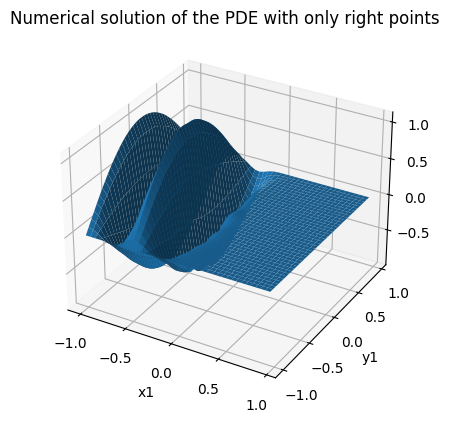

In [ ]:
fig=plot_vectorized_function(u_left)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

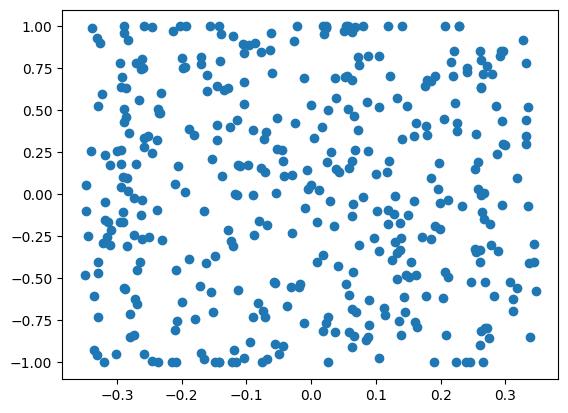

In [ ]:
plt.scatter(u_mid.X_all[:,0],u_mid.X_all[:,1])

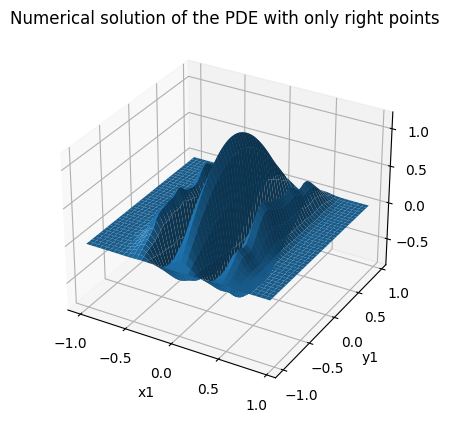

In [ ]:
fig=plot_vectorized_function(u_mid)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

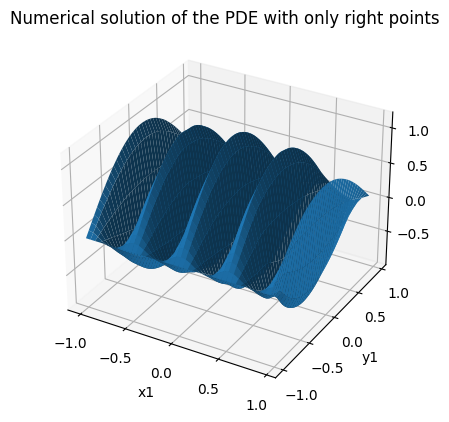

In [ ]:
def dumb_aggregate2(x,models,sep1,sep2):
    which_model=(x[:,0]>sep1).astype(int)+(x[:,0]>sep2).astype(int)
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

local_aggregate=partial(dumb_aggregate2,models=[u_left,u_mid,u_right],sep1=-0.3,sep2=0.3)
fig=plot_vectorized_function(local_aggregate)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

In [ ]:
print(1/0)

In [ ]:
def make_an_aggregate(N_int,N_boundary,nugget=1e-4,sigma=None):
    X_int_left=make_points_inside(N_int)
    X_int_right=make_points_inside(N_int)
    X_boundary_left=make_points_boundary(N_boundary)
    X_boundary_right=make_points_boundary(N_boundary)
    if sigma is None:
        print(3/0)
        sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
    u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left,sigma=sigma,name='left')
    u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
    u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right,sigma=sigma,name='right')
    u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

    aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=nugget)
    return u_left,u_right,aggregate

def get_error(aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    return np.linalg.norm(U_real-U_agg),np.linalg.norm(U_real-U_agg,ord=np.inf)

def make_plot(u_left,u_right,aggregate,clip=(-0.5,1.5)):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
    U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))
    alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))
    clipped=np.clip(alpha,clip[0],clip[1])


    fig,axes=plt.subplots(3,2,figsize=(30,30))
    im = axes[0,0].imshow(np.abs(U_left-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[0,0].title.set_text('error of left model')

    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im2 = axes[0,1].imshow(np.abs(U_right-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=4)
    axes[0,1].title.set_text('error of right model')

    divider = make_axes_locatable(axes[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')


    im3 = axes[1,0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,0].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[1,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=6)
    axes[1,0].title.set_text('error of aggregate')
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    im4 = axes[1,1].imshow(np.abs(U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,1].title.set_text('absolute value of solution')
    divider = make_axes_locatable(axes[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')

    im5 = axes[2,0].imshow(clipped[:,0].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=4)
    axes[2,0].title.set_text('alpha left')

    divider = make_axes_locatable(axes[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical')

    im6 = axes[2,1].imshow(clipped[:,1].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='r',s=4)
    axes[2,1].title.set_text('alpha right')

    divider = make_axes_locatable(axes[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical')

    plt.show()

    


In [ ]:
u_left,u_right,aggregate=make_an_aggregate(N_int=2000,N_boundary=500,nugget=0,sigma=0.1)

Current residual 5.030e-13: : 2it [00:00,  2.37it/s]
Current residual 2.788e-13: : 2it [00:00,  2.07it/s]


M [[-5.82067701e-05  3.88845405e-14]
 [-4.05363697e-05  8.54828587e-14]
 [-1.71434296e-05  1.85854389e-13]
 ...
 [ 1.10178089e-13  1.46243880e-02]
 [ 5.17254857e-14  1.51888879e-02]
 [ 2.40305642e-14  1.55483006e-02]]
COV mat [[[ 9.99984520e-01  4.74458825e-18]
  [ 4.74458825e-18  7.71241439e-24]]

 [[ 9.99993843e-01  6.65708916e-18]
  [ 6.65708916e-18  3.55813269e-23]]

 [[ 9.99997205e-01  6.98810231e-18]
  [ 6.98810231e-18  1.60723210e-22]]

 ...

 [[ 6.56719979e-23 -2.76135026e-17]
  [-2.76135026e-17  9.99991565e-01]]

 [[ 1.45730175e-23 -1.10005481e-17]
  [-1.10005481e-17  9.99992741e-01]]

 [[ 3.16719355e-24 -3.03361081e-18]
  [-3.03361081e-18  9.99996233e-01]]]
COV Y [[9.99984520e-01 7.71241439e-24]
 [9.99993843e-01 3.55813269e-23]
 [9.99997205e-01 1.60723210e-22]
 ...
 [6.56719979e-23 9.99991565e-01]
 [1.45730175e-23 9.99992741e-01]
 [3.16719355e-24 9.99996233e-01]]
alpha [[ 1.00000000e+00  4.74466169e-18]
 [ 1.00000000e+00  6.65713015e-18]
 [ 1.00000000e+00  6.98812184e-18]
 ..

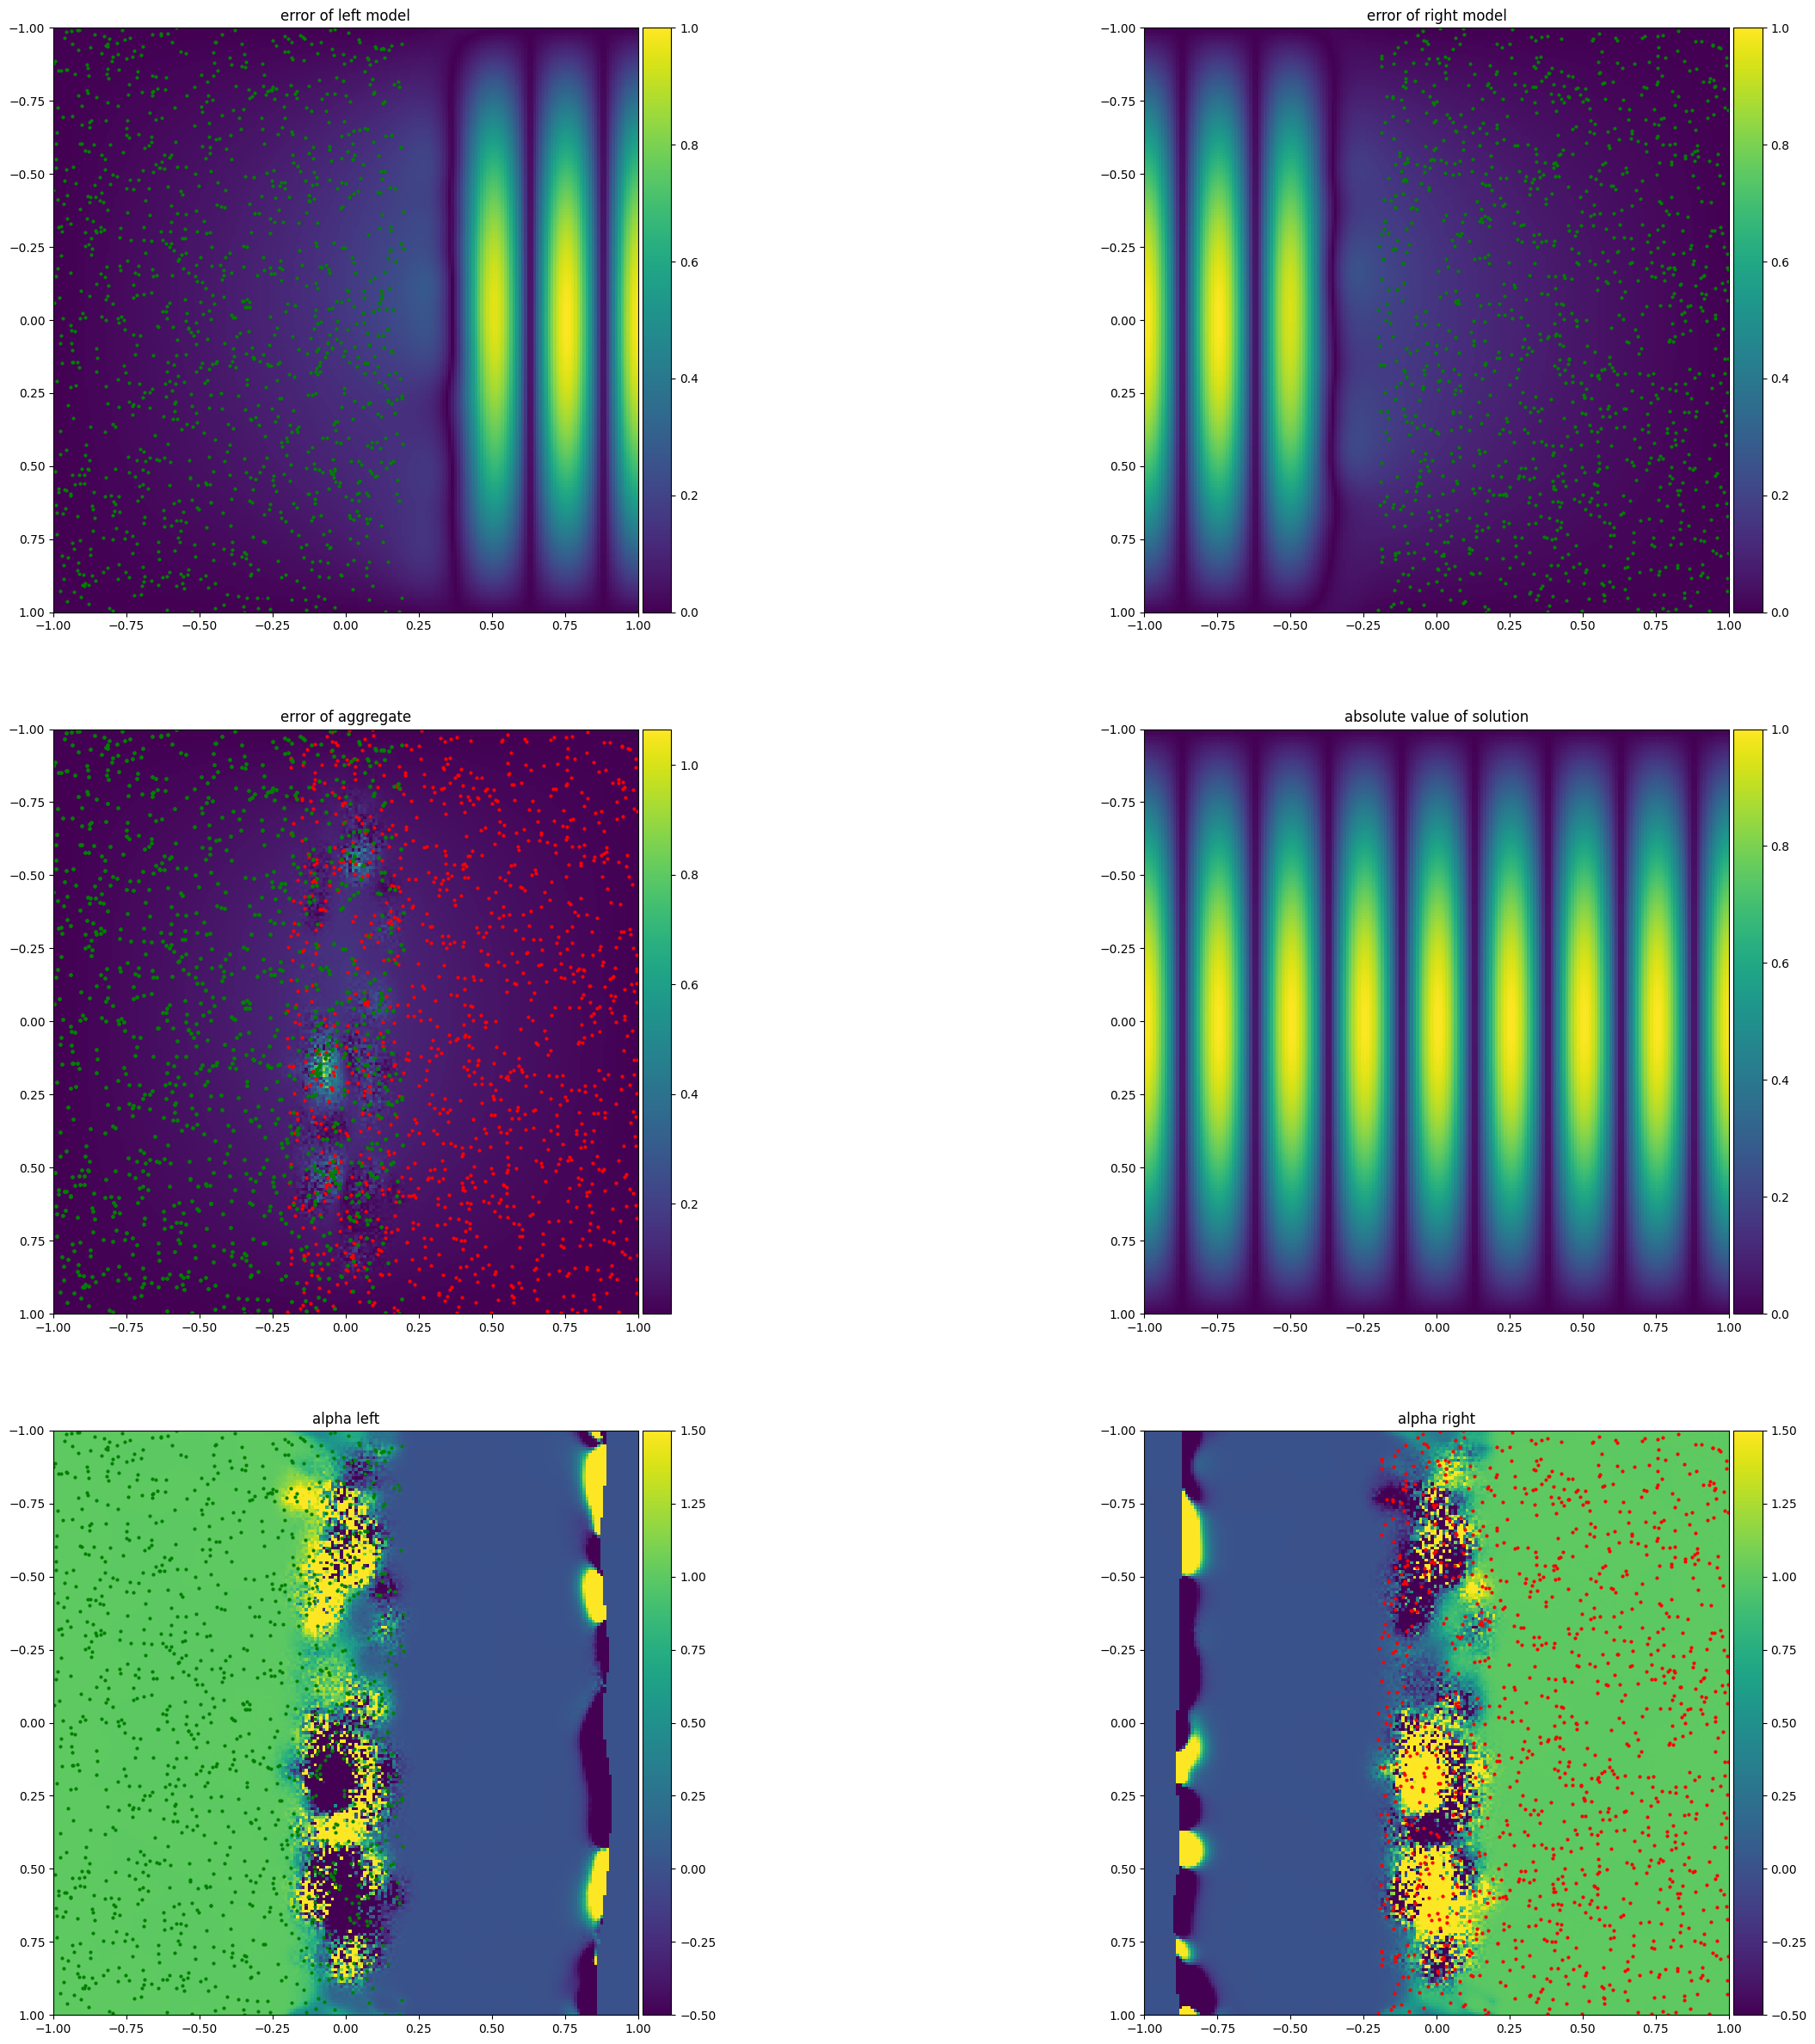

In [ ]:
make_plot(u_left,u_right,aggregate)

In [ ]:
import sys, os

# Disable
#def blockPrint():
#    sys.stdout = open(os.devnull, 'w')

# Restore
#def enablePrint():
#    sys.stdout = sys.__stdout__

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
X_left=X[X<0]
Y_left=Y[X<0]
X_right=X[X>-0.2]
Y_right=Y[X>-0.2]
U_real_left=np.array([real_u([x,y]) for x,y in zip(np.ravel(X_left), np.ravel(Y_left))])
U_real_right=np.array([real_u([x,y]) for x,y in zip(np.ravel(X_right), np.ravel(Y_right))])
Ns=np.linspace(100,10000,10,dtype=np.int32)
errors=[]
for n in Ns:
    print(n)
    with HiddenPrints():
        u_left,u_right,aggregate=make_an_aggregate(N_int=n,N_boundary=n//10,nugget=0,sigma=0.1)
        U_left_left=u_left(np.stack([X_left.flatten(),Y_left.flatten()],axis=-1))
        U_right_right=u_right(np.stack([X_right.flatten(),Y_right.flatten()],axis=-1))
        errors.append([np.linalg.norm(U_left_left-U_real_left,ord=np.inf),np.linalg.norm(U_right_right-U_real_right,ord=np.inf)])
        
errors=np.array(errors)


Current residual 2.001e-15: : 2it [00:00, 441.02it/s]
Current residual 4.474e-15: : 2it [00:00, 354.74it/s]

100
1200



Current residual 1.169e-13: : 2it [00:00,  8.99it/s]
Current residual 1.398e-13: : 2it [00:00,  9.61it/s]


2300


Current residual 4.358e-13: : 2it [00:01,  1.37it/s]
Current residual 4.757e-13: : 2it [00:01,  1.39it/s]


3400


Current residual 4.503e-13: : 2it [00:06,  3.17s/it]
Current residual 5.473e-13: : 2it [00:06,  3.04s/it]


4500


Current residual 6.643e-13: : 2it [00:16,  8.44s/it]
Current residual 1.183e-12: : 2it [00:18,  9.04s/it]


5600


Current residual 4.066e-13: : 2it [00:36, 18.08s/it]
Current residual 2.593e-13: : 2it [00:37, 18.85s/it]


6700


Current residual 1.460e-13: : 2it [01:02, 31.37s/it]
Current residual 3.499e-13: : 2it [01:04, 32.25s/it]


7800


Current residual 3.860e-13: : 2it [01:54, 57.01s/it]
Current residual 5.642e-13: : 2it [01:52, 56.47s/it]


8900


Current residual 6.024e-13: : 2it [02:57, 88.76s/it]
Current residual 1.820e-13: : 2it [02:58, 89.39s/it]


10000


Current residual 8.287e-13: : 2it [04:25, 132.51s/it]
Current residual 3.343e-13: : 2it [03:42, 111.14s/it]


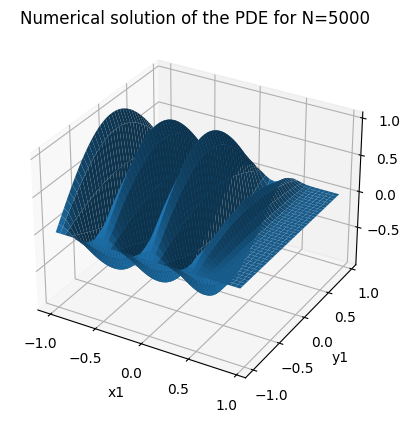

In [ ]:
fig=plot_vectorized_function(u_left,0.05)
plt.title('Numerical solution of the PDE for N=5000')
plt.show()

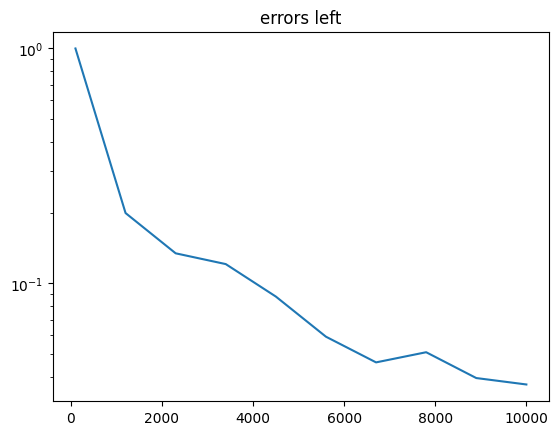

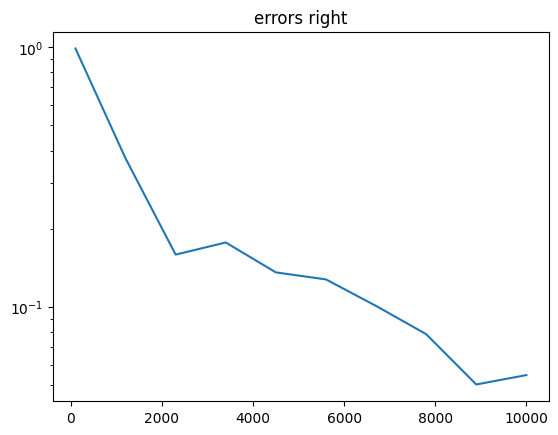

In [ ]:
plt.plot(Ns,errors[:,0])
plt.yscale('log')
plt.title('errors left')
plt.figure()
plt.plot(Ns,errors[:,1])
plt.yscale('log')
plt.title('errors right')
plt.show()

In [ ]:
errors_2=[]
Ns=np.linspace(100,2500,15,dtype=np.int32)
for n in Ns:
    print(n)
    with HiddenPrints():
        u_left,u_right,aggregate=make_an_aggregate(N_int=n,N_boundary=n//10,nugget=0,sigma=0.1)
        L2_error,L_inf_error=get_error(aggregate)
        errors_2.append([L2_error,L_inf_error])

Current residual 2.521e-15: : 2it [00:00, 379.01it/s]
Current residual 1.783e-15: : 2it [00:00, 416.91it/s]

100



Current residual 1.696e-14: : 2it [00:00, 182.46it/s]
Current residual 1.692e-14: : 2it [00:00, 122.84it/s]

271



Current residual 4.413e-14: : 2it [00:00, 75.77it/s]
Current residual 8.014e-14: : 2it [00:00, 70.90it/s]

442



Current residual 1.011e-13: : 2it [00:00, 32.88it/s]
Current residual 1.011e-13: : 2it [00:00, 34.83it/s]

614



Current residual 6.513e-14: : 2it [00:00, 21.18it/s]


785


Current residual 1.046e-13: : 2it [00:00, 19.24it/s]
Current residual 1.191e+00: : 0it [00:00, ?it/s]

957


Current residual 5.353e-14: : 2it [00:00, 13.50it/s]
Current residual 1.028e-13: : 2it [00:00, 13.77it/s]
0it [00:00, ?it/s]

1128


Current residual 1.338e-13: : 2it [00:00,  9.19it/s]
Current residual 1.220e-13: : 2it [00:00, 12.18it/s]
0it [00:00, ?it/s]

1300


Current residual 1.035e-13: : 2it [00:00,  7.23it/s]
Current residual 7.665e-14: : 2it [00:00,  7.76it/s]


1471


Current residual 2.907e-13: : 2it [00:00,  4.93it/s]
Current residual 1.268e-13: : 2it [00:00,  5.00it/s]


1642


Current residual 1.704e-13: : 2it [00:00,  3.46it/s]
Current residual 3.353e-13: : 2it [00:00,  3.42it/s]


1814


Current residual 2.192e-13: : 2it [00:00,  3.98it/s]
Current residual 4.438e-13: : 2it [00:00,  3.90it/s]


1985


Current residual 1.955e-13: : 2it [00:01,  1.75it/s]
Current residual 3.050e-13: : 2it [00:00,  2.02it/s]


2157


Current residual 2.153e-13: : 2it [00:01,  1.20it/s]
Current residual 4.033e-13: : 2it [00:00,  2.09it/s]


2328


Current residual 3.694e-13: : 2it [00:01,  1.53it/s]
Current residual 1.310e-13: : 2it [00:01,  1.57it/s]


2500


Current residual 3.284e-13: : 2it [00:01,  1.12it/s]
Current residual 4.785e-13: : 2it [00:01,  1.24it/s]


In [ ]:
errors_2=np.array(errors_2)

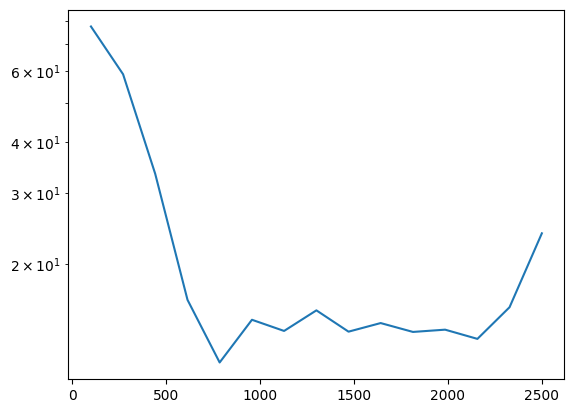

In [ ]:
plt.plot(Ns,errors_2[:,0])
plt.yscale('log')

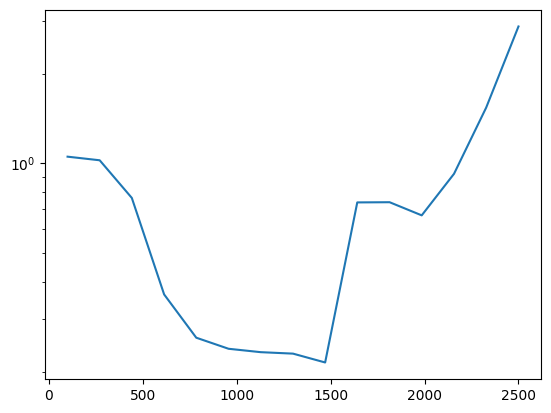

In [ ]:
plt.plot(Ns,errors_2[:,1])
plt.yscale('log')